# Random Forest Classifier for HCP multimodal featureset 

An script for running a simple classification task with data from the Human Connectome Project.

In [62]:
import pandas as pd
import numpy as np
import os 
import rfcode.helpfunctions as hf
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectPercentile
import matplotlib.pyplot as plt
import nibabel
from IPython import display

# iPython specific
%matplotlib inline

First setting paths, reading data matrix and initialising parameters:

In [63]:
dirname='/vol/medic01/users/ecr05/for_ricardo/' 
subjectpath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TRAININGDATA/TRAININGandVALlist.txt'
csvpath='unrestricted.csv' # behavioural spreadsheet
datapath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TESTINGDATA/rfTrainData.npy' # data converted into nxm feature matrix
test_datapath='/vol/medic01/users/ecr05/HCP_PARCELLATION/TESTINGDATA/rfTestData.npy'

variable='Gender' # dependent variable
RANDOM_STATE =42
readtype='HCP_avfeatures'
# set random forest with parameters that have been optimised through 10 fold cross validation
nTrees=1000 
tDepth=9
maxf=75

trainingDATA=hf.read_DATA(datapath,readtype) # read train data
testDATA=hf.read_DATA(test_datapath,readtype) # read test data
xl_file = pd.read_csv(os.path.join(dirname,csvpath)) # read behavioural variable spreadsheet 
subjects=hf.get_subjects(trainingDATA,subjectpath,readtype) # get subjects list 

/vol/medic01/users/ecr05/HCP_PARCELLATION/TRAININGDATA/TRAININGandVALlist.txt


Now extracting the behavioural variable labels from the spreadsheet, checking for missing values, and removing the corresponding rows from the data matrix 

In [64]:
labelvalues=[] # SELECT labels for subset (in future could choose a few and loop over)
deletedrows=[]
for index,subj in enumerate(subjects):
    #print(index,subj)
    if(xl_file.loc[xl_file['Subject']==int(subj),'Gender'].shape !=(0,)):
       # print(xl_file.loc[xl_file['Subject']==int(subj),variables[0]].item())
        labelvalues.append(xl_file.loc[xl_file['Subject']==int(subj),variable].item())
    else:
        # delete data for which there are no labels
        print('delete rows',index,subjects[index])
        deletedrows.append(index)
        
features=np.delete(trainingDATA,deletedrows,0)    

delete rows 246 142626


Now converting the descriptive labels to a discrete index

In [65]:
uniquelabels=np.unique(labelvalues) # CONVERT labels to indices #######
labels=np.zeros((len(labelvalues)))

for index, val in enumerate(uniquelabels):
    labels[np.where(np.asarray(labelvalues)==val)]=index
    
print('features shape',features.shape)
print('labels shape',labels.shape)

features shape (419, 39600)
labels shape (419,)


First thing is to reduce the 360x110 feature space down to something manageable for the Random Forest. RFs perform best when the number of features is less than the number of examples. We will perform feature selection in two stages:

1) Using univariate statistical tests remove all features with low prediction power of individual features. 
2) Feature selection using ensemble learning - in this case random forests (ignoring the circularity of this analysis, for the sake of not introducing any further methods at this stage)

In the first case we will perform univariate F-tests and optimise the selection threshold based on performance of a linear SVM classifier on the subset

The optimal threshold percentile 13
[0.7781260705721138, 0.7709146968139774, 0.74941760877012664, 0.7541452552243918, 0.7636176772867419, 0.76368619390202108, 0.78278520041109978, 0.76128811236724891, 0.75649194929770458, 0.73970537855429941, 0.72785200411099693, 0.75895854744775615, 0.77332990750256936]


/vol/medic01/users/ecr05/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


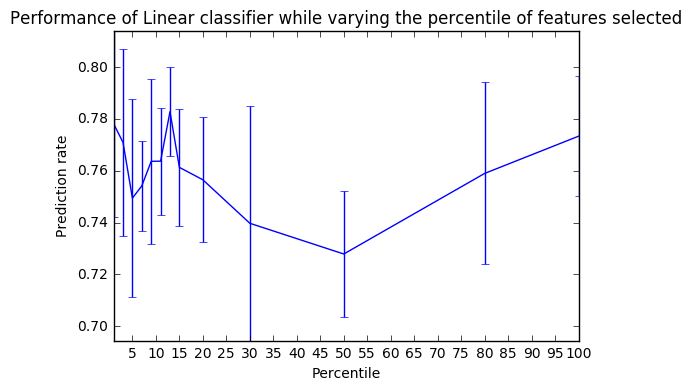

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn import svm
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
transform = SelectPercentile()

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=0.5,kernel='linear'))])
score_means = list()
score_stds = list()
percentiles = (1,3, 5, 7,9, 11,13, 15, 20, 30, 50, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, features, labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

optimal_threshold=percentiles[np.where(score_means==np.max(score_means))[0]]



print('The optimal threshold percentile', optimal_threshold)
print(score_means)

# Plot the distribution
plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of Linear classifier while varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')
plt.xticks(np.arange(0, max(percentiles)+1, 5))
plt.axis('tight')
plt.show()

Now selecting the best features using the optimal threshold and saving the indices of the features used

In [125]:
kbest=SelectPercentile(percentile=optimal_threshold)
featuresbest = kbest.fit_transform(features, labels)
f_mask=kbest.get_support() # mask of features used
indices1=np.where(f_mask==True)
print(np.max(kbest.pvalues_[indices1]))

0.0404087196342


Now performing random forest based feature selection using default rf parameters

after anova testing number of features is  5148


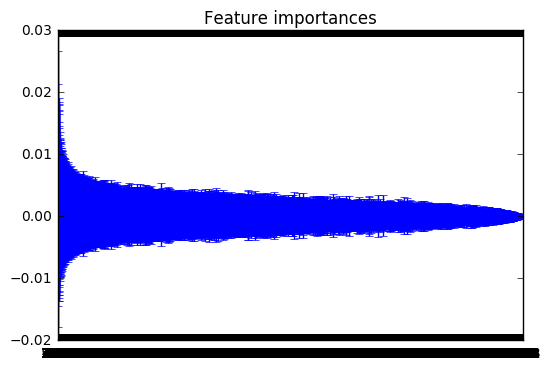

In [126]:
model=RandomForestClassifier(n_estimators=1000,random_state=RANDOM_STATE,n_jobs=-1)
model.fit(featuresbest,labels)
importances=model.feature_importances_

print('after anova testing number of features is ', featuresbest.shape[1])
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(featuresbest.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(featuresbest.shape[1]), indices)
plt.xlim([-1, featuresbest.shape[1]])
plt.show()

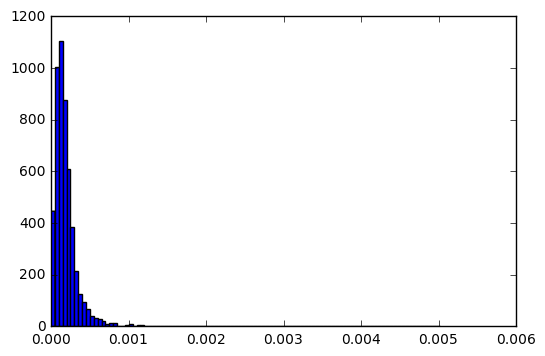

In [127]:
plt.hist(importances,100)
plt.show()

optimal threshold according to linear svm 300 0.849606029462


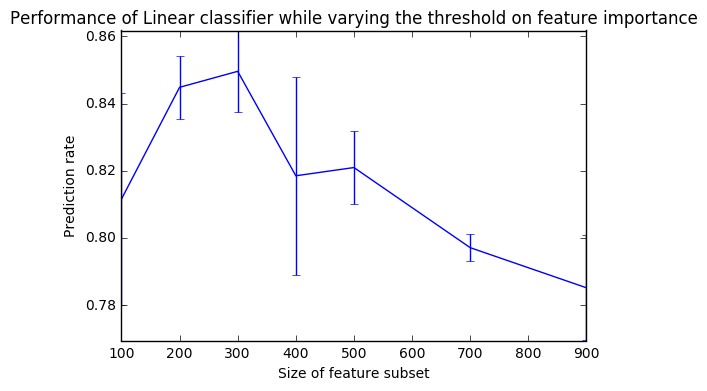

[  100.   350.   600.   850.  1100.  1350.  1600.  1850.]


In [128]:
thresholds = (100,200, 300, 400,500,700,900)
clf=svm.SVC(C=1.0,kernel='linear')
score_means=[]
score_stds=[]
for threshold in thresholds:
    featuresfin=featuresbest[:,indices[:threshold]]
    
   
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, featuresfin, labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

optimal_threshold=thresholds[np.where(score_means==np.max(score_means))[0][0]]
print('optimal threshold according to linear svm',optimal_threshold, np.max(score_means))

# Plot the distribution
plt.errorbar(thresholds, score_means, np.array(score_stds))

plt.title(
    'Performance of Linear classifier while varying the threshold on feature importance')
plt.xlabel('Size of feature subset')
plt.ylabel('Prediction rate')
plt.xticks(np.arange(100.0,1000.0,100))
plt.axis('tight')
plt.show()
print(np.arange(100.0,2000.0,250))

optimal threshold according to rf 300 0.861579307982


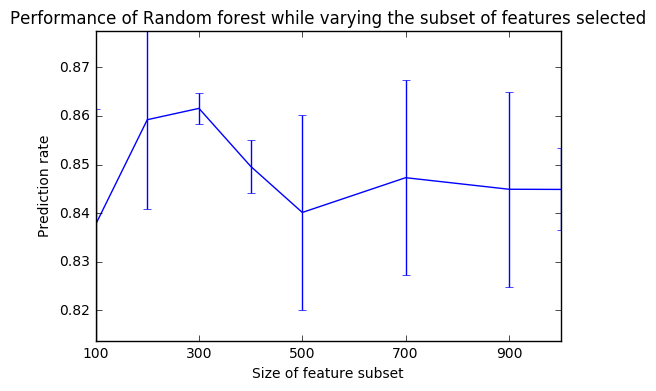

[  100.   350.   600.   850.  1100.  1350.  1600.  1850.]


In [129]:
thresholds = (100,200, 300, 400,500,700,900,1000)
clf=RandomForestClassifier(n_estimators=1000,random_state=RANDOM_STATE,n_jobs=-1)
score_means=[]
score_stds=[]
for threshold in thresholds:
    featuresfin=featuresbest[:,indices[:threshold]]
    
   
    # Compute cross-validation score using 1 CPU
    this_scores = cross_val_score(clf, featuresfin, labels, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

optimal_threshold=thresholds[np.where(score_means==np.max(score_means))[0][0]]
print('optimal threshold according to rf',optimal_threshold, np.max(score_means))
# Plot the distribution
plt.errorbar(thresholds, score_means, np.array(score_stds))

plt.title(
    'Performance of Random forest while varying the subset of features selected')
plt.xlabel('Size of feature subset')
plt.ylabel('Prediction rate')
plt.xticks(np.arange(100.0,2000.0,200))
plt.axis('tight')
plt.show()
print(np.arange(100.0,2000.0,250))

In [130]:
print(optimal_threshold)

300
